# PPP2R1A
[Houge-Janssens syndrome-2 (HJS2)](https://omim.org/entry/616362) is caused by heterozygous mutation in the PPP2R1A gene.

In [1]:
import gpsea
import hpotk
store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.6.1.dev0


# PPP2R1A
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PPP2R1A.

In [2]:
gene_symbol = "PPP2R1A"
mane_tx_id = 'NM_014225.6'
mane_protein_id = "NP_055040.2"

### Load phenopackets

We'll load the phenopacket JSON files stored in the `phenopackets` folder next to the notebook.

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = gene_symbol
phenopacket_store_release = '0.1.20'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Individuals Processed: 100%|██████████| 60/60 [00:00<00:00, 932.29individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_75189/3430112688.py:9: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


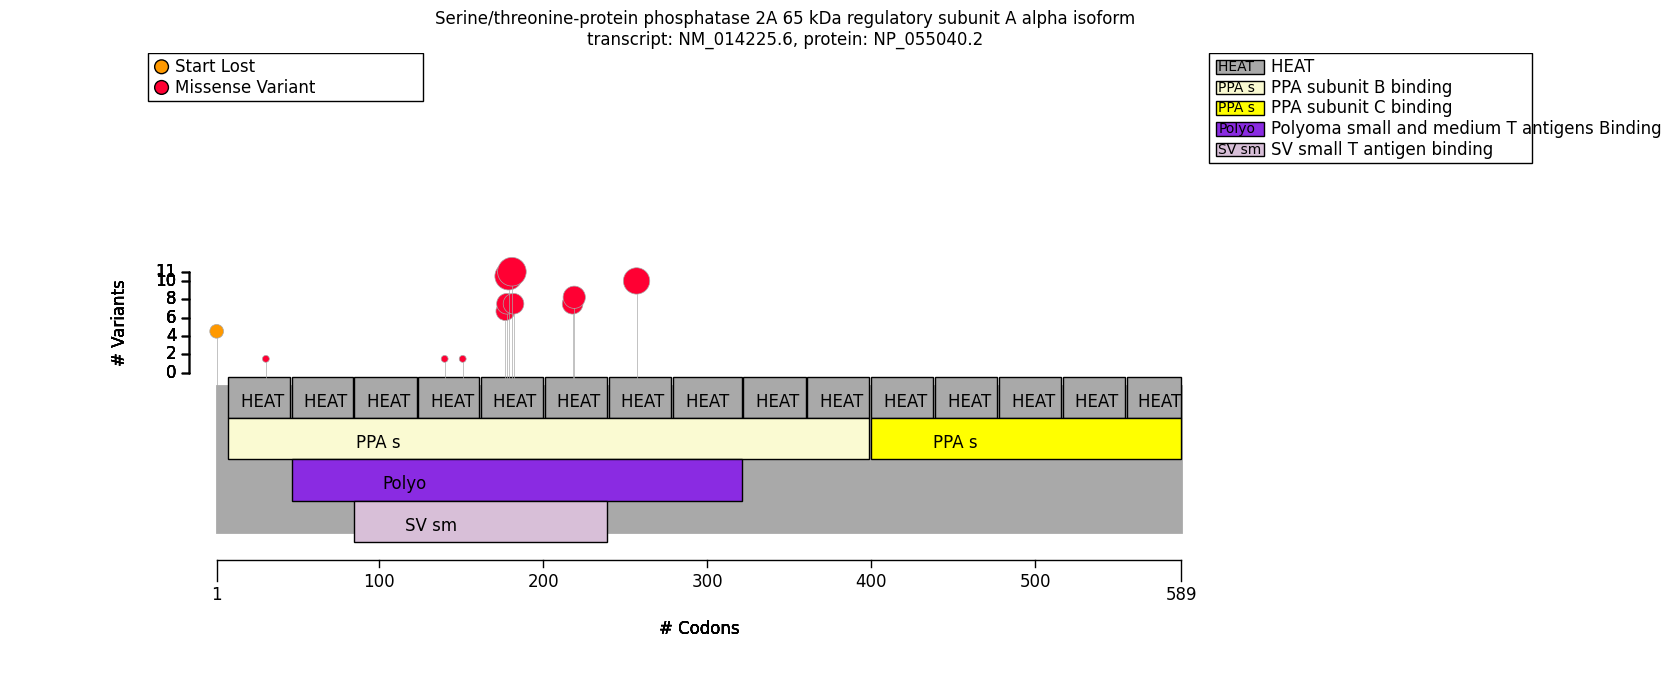

In [5]:
from gpsea.model.genome import GRCh38

from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)

pms = configure_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
ax = drawer.draw_fig(pvis=pvis)

In [6]:
from gpsea.view import ProteinVariantViewer
cpd_viewer = ProteinVariantViewer(tx_id=mane_tx_id, protein_metadata=protein_meta)
report = cpd_viewer.process(cohort)
report  

In [7]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.4,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

## Run analysis

Test for genotype-phenotype correlation between variants located in some protein region vs. the variants outside of the region.

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

is_r182w = VariantPredicates.variant_key("19_52212726_52212726_C_T") #c.544C>T	p.Arg182Trp

is_r182w_pred = monoallelic_predicate(a_predicate=is_r182w,
                                    b_predicate=~is_r182w,
                                    a_label="Arg182Trp",
                                    b_label="other")


print(is_r182w_pred.display_question())
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_r182w_pred,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Allele group: Arg182Trp, other


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       Arg182Trp          other  \
                                                       Count Percent  Count   
Abnormality of skull size [HP:0000240]                   3/3    100%  30/30   
Abnormal axial skeleton morphology [HP:0009121]          5/5    100%  33/33   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]        11/11    100%  29/29   
Aplasia/Hypoplasia involving the central nervou...     11/11    100%  29/29   
Morphological central nervous system abnormalit...     11/11    100%  32/32   
Abnormal cerebral morphology [HP:0002060]              11/11    100%  31/31   
Abnormal forebrain morphology [HP:0100547]             11/11    100%  31/31   
Abnormal brain morphology [HP:0012443]                 11/11    100%  32/32   
Intellectual disability [HP:0001249]                     8/8    100%  36/36   
Neurodevelopmental abnormality [HP:0012759]            10/10    100%  44/44   
Delayed speech and language development [HP:000...       6/6    100%  29/29   
Neurodevelopmental delay [HP:0012758]                    8/8    100%  38/38   
Abnormal communication [HP:0034434]                      6/6    100%  29/29   
Abnormal speech pattern [HP:0002167]                     6/6    100%  29/29   
Motor delay [HP:0001270]                                 7/7    100%  22/22   
Seizure [HP:0001250]                                     7/7    100%  17/17   
Aplasia/Hypoplasia of the corpus callosum [HP:0...     11/11    100%  26/26   
Abnormal cerebral white matter morphology [HP:0...     11/11    100%  27/27   
Feeding difficulties [HP:0011968]                        3/3    100%  30/30   
Hypotonia [HP:0001252]                                   8/8    100%  34/34   

Allele group                                                                   \
                                                   Percent Corrected p values   
Abnormality of skull size [HP:0000240]                100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal forebrain morphology [HP:0100547]            100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   
Motor delay [HP:0001270]                              100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Aplasia/Hypoplasia of the corpus callosum [HP:0...    100%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Feeding difficulties [HP:0011968]                     100%                1.0   
Hypotonia [HP:0001252]                                100%                1.0   

Allele group                                                 
                                                   p values  
Abnormality of skull size [HP:0000240]                  1.0  
Abnormal axial skeleton morphology [HP:0009121]         1.0  
Aplasia/Hypoplasia of the cerebrum [HP:0007364]         1.0  
Aplasia/Hypoplasia involving the central nervou...      1.0  
Morphological central nervous system abnormalit...      1.0  
Abnormal cerebral morphology [HP:0002060]   

In [10]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.genotype import ProteinPredicates

pp = ProteinPredicates(pms)
is_region = pp.protein_feature_type(feature_type=FeatureType.REGION, tx_id=PPP2R1A_transcript_id)
by_region = hpo_analysis.compare_hpo_vs_genotype(is_region)
by_region.summarize(hpo, PatientCategories.YES)

NameError: name 'PPP2R1A_transcript_id' is not defined

TODO - finalize!